In [1]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import normalize

In [2]:

# Clean the environment (Python doesn't require explicit cleaning)
# Load Data
shannon_img_path = '../SpectralPatang/data/ang20190706t235120rfl/result/ang20190706t235120_rfl_v2v2_img_rectified/SPCA/PCA/OutputPCA_30_PCs_selection_cut.tif'
csv_path = "../SpectralPatang/data/ang20190706t235120rfl/clustertest/data/species_analysis/06_Utqiagvik_IBP_R_Input.csv"


In [3]:
# Read raster image
with rasterio.open(shannon_img_path) as src:
    shannon_img = src.read(1)  # Read the first band

In [4]:
# Read and clean the CSV
plot_data = pd.read_csv(csv_path)
plot_data.replace(-9, np.nan, inplace=True)  # Replace -9 with NaN

In [5]:
# Dynamically select "Releve number", "Number of species", and all species columns
species_start_idx = plot_data.columns.get_loc('Number of species') + 1
selected_data = plot_data.iloc[:, [0, species_start_idx - 1] + list(range(species_start_idx, plot_data.shape[1]))]

# Separate species table
species_table = selected_data.iloc[:, 2:]
species_table.fillna(0, inplace=True)  # Replace NaN with 0

# Normalize species data so that rows sum to 1
species_table_normalized = species_table.div(species_table.sum(axis=1), axis=0)

# Calculate Shannon Diversity Index
def shannon_index(row):
    row_nonzero = row[row > 0]  # Avoid log(0)
    return -np.sum(row_nonzero * np.log(row_nonzero))

plot_data['Shannon_Index'] = species_table_normalized.apply(shannon_index, axis=1)

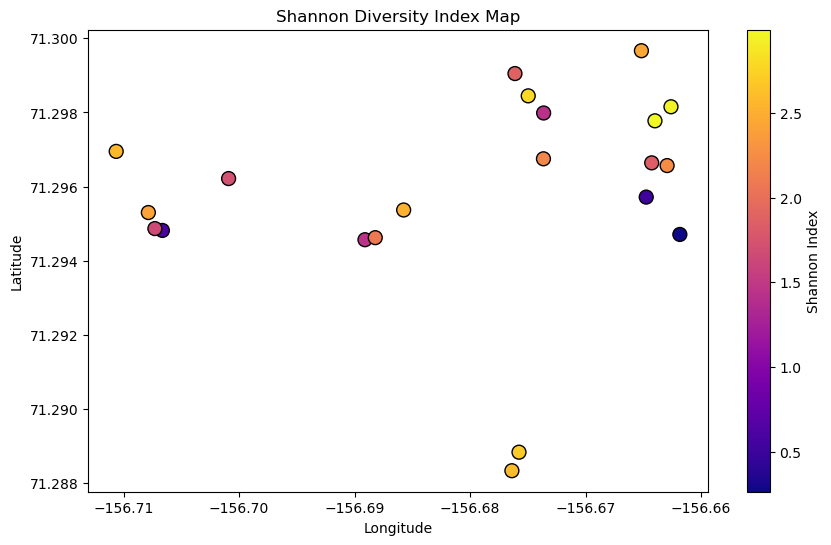

In [6]:
# Create a figure and axis
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    plot_data["Longitude"],
    plot_data["Latitude"],
    c=plot_data["Shannon_Index"],  # Color by Shannon Index
    cmap="plasma",                # Color map
    s=100,                        # Size of points
    edgecolor="k"                 # Add edge color for visibility
)
plt.colorbar(scatter, label="Shannon Index")  # Add colorbar
plt.title("Shannon Diversity Index Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [7]:
# ** Interactive Map with Folium **
m = folium.Map(location=[plot_data['Latitude'].mean(), plot_data['Longitude'].mean()], zoom_start=10)

# Add points to map
for _, row in plot_data.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=0.8,
        popup=f"<b>Releve number:</b> {row['Releve number']}<br><b>Shannon Index:</b> {row['Shannon_Index']:.2f}"
    ).add_to(m)

# Add raster image as heatmap overlay
heat_data = [[row['Latitude'], row['Longitude'], row['Shannon_Index']] for _, row in plot_data.iterrows()]
HeatMap(heat_data).add_to(m)

# Save map
m.save('shannon_map.html')

# ** Plot Comparison with ENVI File **
# Simulate ENVI Shannon Index Values for demonstration
envi_shannon_values = np.linspace(min(plot_data['Shannon_Index']), max(plot_data['Shannon_Index']), len(plot_data))

comparison_df = pd.DataFrame({
    "Ground": plot_data['Shannon_Index'],
    "ENVI": envi_shannon_values
})

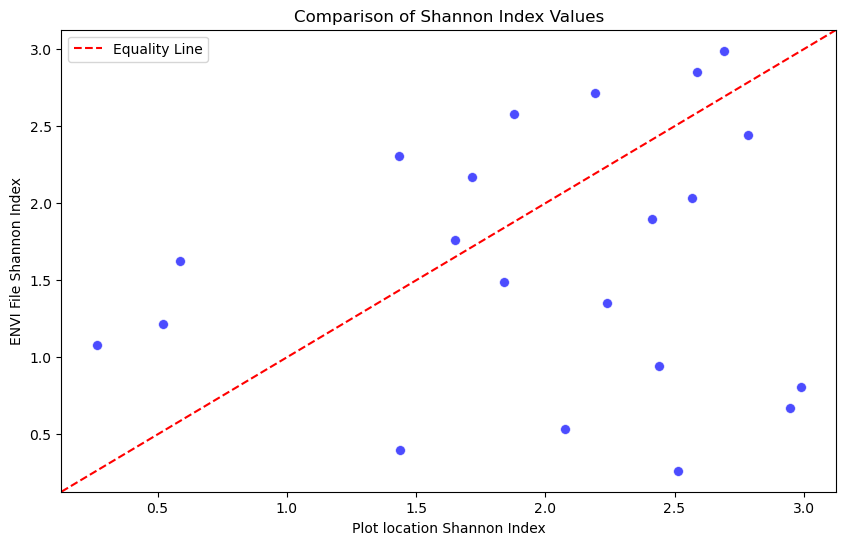

In [8]:
# Scatter Plot: ENVI vs Ground Shannon Index
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['Ground'], y=comparison_df['ENVI'], color='blue', s=50, alpha=0.7)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle="--", color="red", label="Equality Line")
plt.title("Comparison of Shannon Index Values")
plt.xlabel("Plot location Shannon Index")
plt.ylabel("ENVI File Shannon Index")
plt.legend()
plt.show()

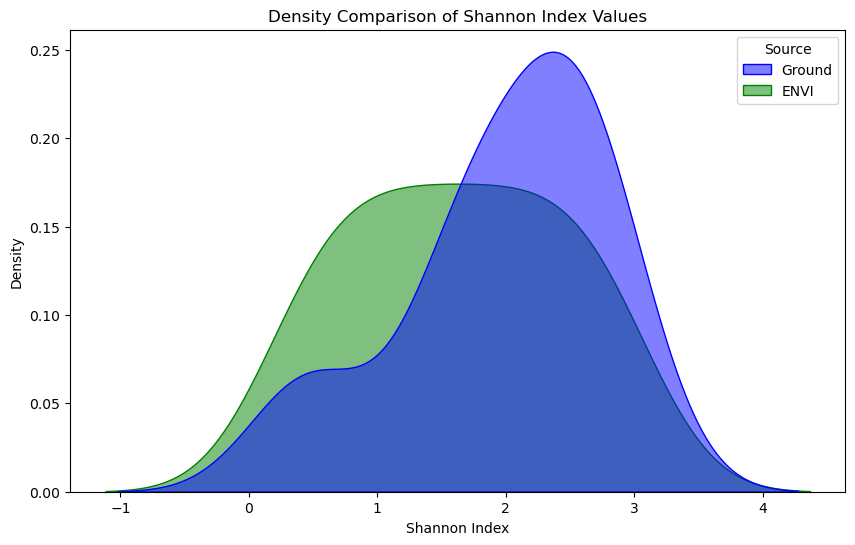

In [9]:
# ** Density Comparison **
melted_df = pd.melt(comparison_df, var_name="Source", value_name="Shannon_Index")

plt.figure(figsize=(10, 6))
sns.kdeplot(data=melted_df, x="Shannon_Index", hue="Source", fill=True, alpha=0.5, palette=["blue", "green"])
plt.title("Density Comparison of Shannon Index Values")
plt.xlabel("Shannon Index")
plt.ylabel("Density")
plt.show()